### Criação das bolinhas

pygame 2.5.0 (SDL 2.28.0, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


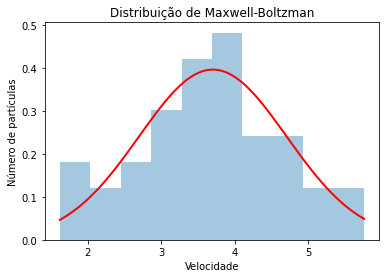

In [1]:
import numpy as np
import pygame
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Inicialização do pygame
pygame.init()

# Parâmetros
num_atoms = 40
temperatura = 8 # em Kelvin
raio = 4
massa = 20

# Parâmetros da janela
width, height = 800, 600
window = pygame.display.set_mode((width, height))
pygame.display.set_caption("Simulação da Colisão Elástica")

# Cores
white = (255, 255, 255)
red = (255, 0, 0)

### Preciso definir as bolinhas, quem são e como serão representadas

## Tem uma velocidade no eixo x, velocidade no eixo y, posição inicial em x e posição inicial em y

## Vamos fazer a representação das bolinhas utilizando matrizes do numpy, preenchida com zeros e 1, sendo 1 a representação dela
class atomo:
    """Essa classe irá representar os nossos átomos,
    
    Terá a posição inicial deles, sua velocidade em x e y, e o seu raio."""
    
    def __init__(self,x,y, raio, temperatura, massa, syles=None):
        '''definindo como que cada parâmetro irá se inicializar'''
    
        #Para gerar os valores aleatórios vamos utilizar uma função do numpy chamda random uniform que gera valores aleatórios seguindo 
        ## um intervalo de valores específicado
        
        self.p = np.array((x,y)) #defino a posição das bolinhas
        vx = random.randint(-4,4)
        vy = random.randint(-4,4)
        self.v = np.array((vx,vy))
        self.caract = np.array((temperatura,massa,raio)) #Definindo características das bolinhas
      
    # Movimento das bolinhas
    
    def movimento(self):
    
        self.p = self.p + self.v

        #Restringir a região das bolinhas

        self.p[0] = max(self.caract[2], min(self.p[0], width - self.caract[2]))
        self.p[1] = max(self.caract[2], min(self.p[1], height - self.caract[2]))
        
    #Verificando se há colisão entre elas
    
    def verifica_colisao(self,b2):
        distance = math.sqrt((self.p[0] - b2.p[0])**2 + (self.p[1] - b2.p[1])**2)
        return distance <= self.caract[2] + b2.caract[2]
     

    def aplica_colisao(self,b2):
        
        dx = b2.p[0] - self.p[0]
        dy = b2.p[1] - self.p[1]
        
        distancia = math.sqrt(dx**2 + dy**2)
        
        dx_futuro = (b2.p[0] + b2.v[0]) - (self.p[0] + self.v[0])
        dy_futuro = (b2.p[1] + b2.v[1]) - (self.p[1] + self.v[1])
        distancia_futura = math.sqrt(dx_futuro**2 + dy_futuro**2)
        
        if distancia_futura < distancia:
            m1,m2 = 4e-23, 4e-23#self.caract[2]**2, b2.caract[2]**2
            M = m1 + m2
            r1,r2 = self.p, b2.p
            
            d = np.linalg.norm(r1-r2)**2
                
            v1, v2 = abs(self.v), abs(b2.v)
            u1 = v1 - 2*m2/M *(np.dot(v1-v2,r1-r2)/d)* (r1-r2)
            u2 = v2 - 2*m1/M * np.dot(v2-v1,r2-r1)/d * (r2-r1)
            self.v = u1
            b2.v = -u2
    
    def colisao_parede(self):
        
            # Refletir a direção da bola quando colide com as paredes
        if (self.p[0] - self.caract[2] <= 0).any(): #and self.v[0] < 0
            self.v[0] = -self.v[0]
            
        if (self.p[0] + self.caract[2] >= width).any(): #and self.v[0] > 0:
            self.v[0] = -self.v[0]

        if (self.p[1] - self.caract[2] <= 0).any(): #and self.v[1] < 0:
            self.v[1] = -self.v[1]
            
        if (self.p[1] + self.caract[2] >= height).any(): # and self.v[1] > 0 :
            self.v[1] = -self.v[1]     
                


 
#lista de atomos

atomos = []

for _ in range(num_atoms):
    valid_position = False
    while not valid_position:
        x = random.randint(50, width - 50)
        y = random.randint(50, height - 50)
        
        #a = atom.p
        
        # Verificar se a posição não está muito próxima de outras posições já escolhidas
        if all(math.sqrt((x-atom.p[0])**2 + (y - atom.p[1])**2) >= 3 * atom.caract[2] for atom in atomos):
            if all(math.sqrt((x - atom.p[0])**2 + (y - atom.p[1])**2) >= 3 * atom.caract[2] for atom in atomos):
                valid_position = True

    atom = atomo(x, y, raio, temperatura, massa)
    atomos.append(atom)
    
# Loop principal
running = True
clock = pygame.time.Clock()

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    window.fill(white)

    for atom in atomos:
        atom.movimento()
        atom.colisao_parede()
        pygame.draw.circle(window, red, (int(atom.p[0]), int(atom.p[1])), atom.caract[2])

    # Verificar colisões
    for i in range(len(atomos)):
        for j in range(i + 1, len(atomos)):
            if atomos[i].verifica_colisao(atomos[j]):
                atomos[i].aplica_colisao(atomos[j])
                

    pygame.display.flip()
    clock.tick(200)


pygame.quit()

# Coletar as velocidades das partículas ao longo do tempo
velocidades = []
for a in atomos:
    v_norm = (((a.v[0])**2)+((a.v[1])**2))**(1/2)
    velocidades.append(v_norm)

# Criar um histograma das velocidades
plt.figure()
plt.hist(velocidades, bins=10, density=True, alpha=0.4)

# Ajustar os dados a uma distribuição gaussiana usando a função norm.fit()
mu, sigma = norm.fit(velocidades)

# Calcular a distribuição gaussiana ajustada
x = np.linspace(np.min(velocidades), np.max(velocidades), 100)
normalizado = norm.pdf(x, mu, sigma)
plt.plot(x, normalizado,  color='red',linewidth=2)

plt.xlabel('Velocidade')
plt.ylabel('Número de partículas')
plt.title('Distribuição de Maxwell-Boltzman')
plt.show()
        